## Parameter and import


In [ ]:
import sys

sys.path.append("..")

from updpc.updpc_algorithm import *
from updpc.thorcam_controller import *
try:
    from updpc.pycromanager_utils import *
except Exception as e:
    print("Not using microscope, just for debugging.")
    print(e)

In [ ]:
compress_num = 2
sample_imgs = np.zeros((4, 1024 // compress_num, 1224 // compress_num)) # For ThorCam

In [ ]:
def compress_array(imgs, compress_num=compress_num):
    """
    Compresses an array of images by a factor of compress_num

    Parameters
    ----------
    imgs : np.ndarray
        Array of images to compress

    Returns
    -------
    np.ndarray
        Compressed array of images converted to float16
    """
    return np.array([compress(img, compress_num) for img in imgs], dtype=np.float16)

In [ ]:
na_in = 0.330
w_in = 0.073
na_cos = 1.435
na_ill = 1.33

In [ ]:
wavelength = 0.660  # in micron
mag, na = 1000 / 3, 1.4

pixel_size_cam = 3.45 * 2 * compress_num  # pixel size of camera in micron
pixel_size = pixel_size_cam / mag  # in micron

source_pols = [[90, -45], [45, 0]]
a0 = 1

In [ ]:
reg_p = 1e-1
reg_u = reg_p

## Set your output directory!!


In [ ]:
out_dir = "../data/raw/"
makedirs(out_dir, exist_ok=True)

## Compute background; Set the good exposure time!!

Suppose we already have the background QuadView tif images with ThorCam software whose name includes 'background'.

Don't forget to set the same exposure time as for the background images!

<AxesSubplot:>

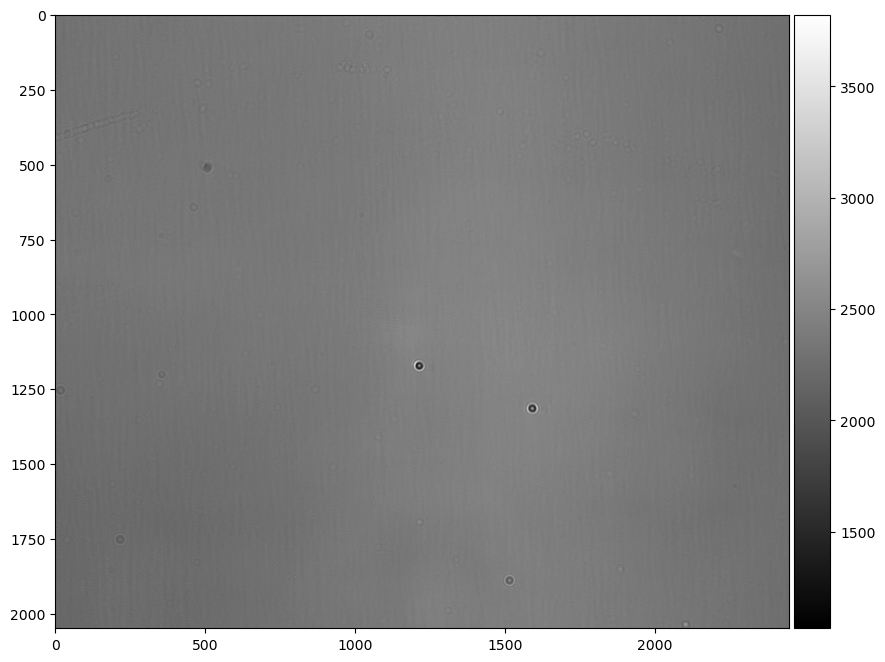

In [ ]:
exposure_time_bg = 9  # ms
bg = quad_to_raw(
    np.median(
        [
            imread(path).mean(axis=0)
            for path in list_tifs(out_dir, include="background", exclude="background.tif")
        ],
        axis=0,
    )
)
imshow(bg)

<AxesSubplot:>

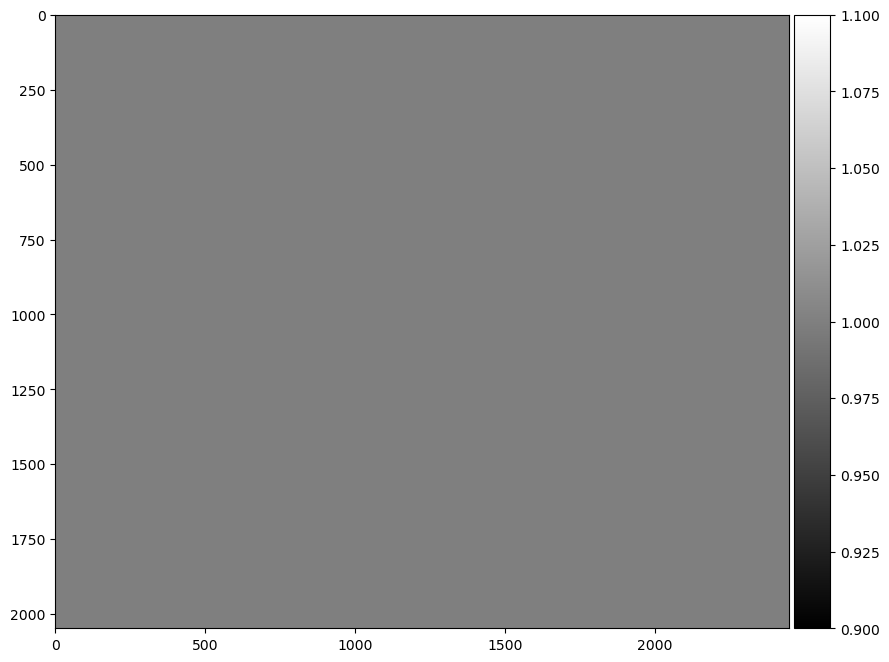

In [ ]:
# If you have a fluorescence background image, you can load it here
bg_flu = np.ones((1024 * 2, 1224 * 2))
imshow(bg_flu)

## Preparation (Run anyway!)


### Fast phase retrieval


In [ ]:
solver = UpDPCSolver(sample_imgs, wavelength, na, na_in, pixel_size, source_pols, na_ill, na_cos, w_in, a0)
Hp = solver.Hp

denominator = (Hp.conj() * Hp).sum(axis=0) + reg_p


def fastPH(dpc_imgs):
    """
    Fast phase retrieval algorithm

    Parameters
    ----------
    dpc_imgs : np.ndarray
        Array of DPC images

    Returns
    -------
    np.ndarray
        Phase image
    """
    fIntensity = np.asarray([F(img / img.mean() - 1) for img in dpc_imgs])
    AHy = (Hp.conj() * fIntensity).sum(axis=0)
    return auto_contrast(IF(AHy / denominator).real, return_int=True)

### BF, Fluorescent, ph


In [ ]:
def Quad_from_Raw(image):
    """
    Converts a raw image to a quad image with background correction.

    Parameters
    ----------
    image : np.ndarray
        Raw image

    Returns
    -------
    np.ndarray
        Quad image
    """
    return auto_contrast(
        quadlist_to_quad(compress_array(raw_to_quadarray(image / bg), compress_num * 2)),
        0,
        True,
    )


live_tr, rec_tr = make_live_rec_func(Quad_from_Raw)

In [ ]:
def Flu_from_Raw(image):
    """
    Converts a raw image to a fluorescence intensity image with background correction.

    Parameters
    ----------
    image : np.ndarray
        Raw image

    Returns
    -------
    np.ndarray
        Fluorescence intensity image
    """
    return auto_contrast(compress(raw_to_intensity(image.astype(float)), compress_num))


live_flu, rec_flu = make_live_rec_func(Flu_from_Raw)

In [ ]:
def fastPH_from_Raw(image):
    """
    Fast phase retrieval algorithm from a raw image

    Parameters
    ----------
    image : np.ndarray
        Raw image

    Returns
    -------
    np.ndarray
        Phase image
    """
    return fastPH(compress_array(raw_to_quadarray(image / bg), compress_num))


live_ph, rec_ph = make_live_rec_func(fastPH_from_Raw)

## Acquisition


In [ ]:
## BrightField
live_tr(exposure_time_ms=exposure_time_bg)

Exposure time is 9.001 ms. Push Enter


Image acquisition has stopped


In [ ]:
## Phase
live_ph(exposure_time_ms=exposure_time_bg)

Exposure time is 9.001 ms. Push Enter


Image acquisition has stopped


In [ ]:
filename = "rec_ph_test"

rec_ph(exposure_time_ms=exposure_time_bg, out_dir=out_dir, filename=filename)

Exposure time is 9.001 ms. Push Enter


Generating app...
Setting camera parameters...
Starting image acquisition thread...
App starting
Waiting for image acquisition thread to finish...
Image acquisition has stopped, reached inf frame
Closing resources...
Finished.


In [ ]:
rec_flu(exposure_time_ms=200, out_dir=out_dir, filename=filename + "_flu")
set_channel()